![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/lab_2/practica_4/practica_4.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

# **Pŕactica No. 4**
## **Introducción al Autoencoder**

## **Objetivos**
- Introducirnos a la arquitectura del Autoencoder
- Procesar imágenes con Deep Learning

## **Problema**
- Se busca clasificar un dataset con imágenes de ropa, sin embargo, los datos se tomaron con una cámara en mal estado, por lo que salieron con algo de ruido en sus píxeles. Nuestro deber como ingenieros, es hacer uso del Deep Learning para limpiar el ruido de estas imágenes.


In [1]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from skimage import util

from utils import general as gen

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
(full_X_train, _), (X_test, _) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
full_X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
np.random.seed(0)
random_sample = np.random.choice(len(full_X_train), size=9)

## **Visualización y Preparación**

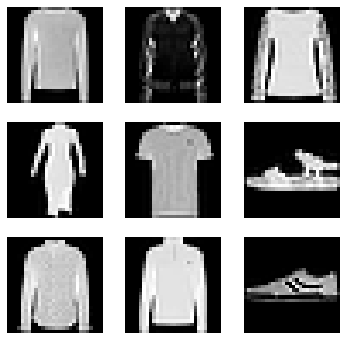

In [6]:
gen.visualize_subplot(
    full_X_train[random_sample],
    [""] * len(random_sample), 
    (3, 3), (6, 6)
)

In [7]:
full_X_train = full_X_train / 255.
X_test = X_test / 255.

In [8]:
full_noise_X_train = np.zeros_like(full_X_train)

for idx, img in enumerate(full_X_train):
    full_noise_X_train[idx] = util.random_noise(
        img, mode="gaussian", seed=1234
    )

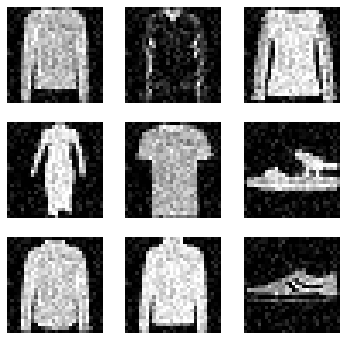

In [9]:
gen.visualize_subplot(
    full_noise_X_train[random_sample],
    [""] * len(random_sample), 
    (3, 3), (6, 6)
)

In [10]:
noise_X_train, noise_X_val, X_train, X_val = train_test_split(
    full_noise_X_train, full_X_train, test_size=0.2, random_state=1234
)

In [11]:
noise_X_test = np.zeros_like(X_test)

for idx, img in enumerate(X_test):
    noise_X_test[idx] = util.random_noise(
        img, mode="gaussian", seed=1234
    )

In [12]:
np.random.seed(0)
random_sample = np.random.choice(len(X_test), size=9)

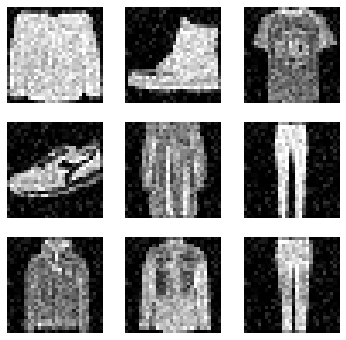

In [13]:
gen.visualize_subplot(
    noise_X_test[random_sample],
    [""] * len(random_sample), 
    (3, 3), (6, 6)
)

## **Modelado**
- Aquí haremos uso del Autoencoder como arquitectura de limpieza de imágenes.

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(32, activation="selu"),
    keras.layers.Dense(16, activation="selu"),
    keras.layers.Dense(32, activation="selu"),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(np.multiply(*full_X_train.shape[1:])),
    keras.layers.Reshape(full_X_train.shape[1:])
])

In [19]:
model_kwargs = {
    "loss": keras.losses.MeanSquaredError(),
    "optimizer": "adam"
}

In [20]:
model.compile(**model_kwargs)

In [21]:
train_args = (noise_X_train, X_train)

train_kwargs = {
    "batch_size": 64,
    "validation_data": (noise_X_val, X_val),
    "epochs": 20
}

history = model.fit(*train_args, **train_kwargs)

Epoch 1/20
750/750 [==============================] - 4s 4ms/step - loss: 0.0350 - val_loss: 0.0242
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0226 - val_loss: 0.0216
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0208 - val_loss: 0.0202
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0197 - val_loss: 0.0193
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0189 - val_loss: 0.0186
Epoch 6/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 7/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0178 - val_loss: 0.0176
Epoch 8/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 9/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 10/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0170 - val_loss: 0.0169

In [22]:
history = pd.DataFrame(history.history)

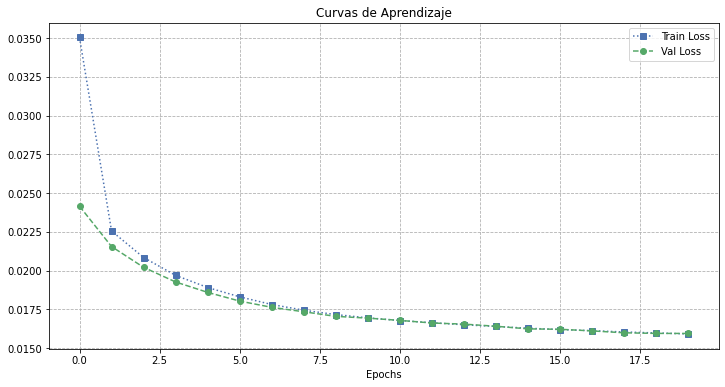

In [23]:
plt.figure(figsize=(12, 6))

plt.plot(history["loss"], "s", label="Train Loss", linestyle="dotted")
plt.plot(history["val_loss"], "o", label="Val Loss", linestyle="dashed")
plt.title("Curvas de Aprendizaje")
plt.xlabel("Epochs")
plt.legend(loc="best")
plt.grid(linestyle="--")
plt.show()

## **Validación**

In [24]:
denoised_X_test = model.predict(noise_X_test)

In [25]:
mean_absolute_error(denoised_X_test.flatten(), X_test.flatten())

0.08012294146928035

In [26]:
mean_squared_error(denoised_X_test.flatten(), X_test.flatten())

0.015974953414534785

In [27]:
r2_score(denoised_X_test.flatten(), X_test.flatten())

0.8512104767038731

In [28]:
np.random.seed(0)
random_sample = np.random.choice(len(X_test), size=9)

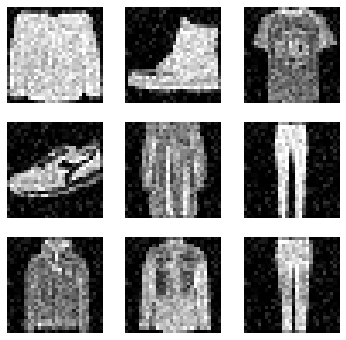

In [30]:
gen.visualize_subplot(
    noise_X_test[random_sample],
    [""] * len(random_sample), 
    (3, 3), (6, 6)
)

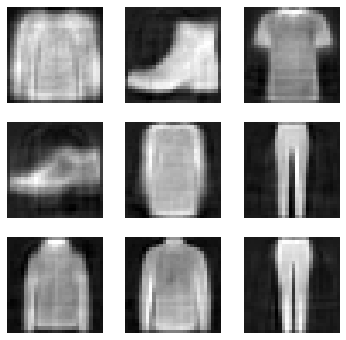

In [31]:
gen.visualize_subplot(
    denoised_X_test[random_sample],
    [""] * len(random_sample), 
    (3, 3), (6, 6)
)